# InterAMPM Experiment Results

**Author**: Medha Agarwal

**Last Modified**: July 07, 2024

In this notebook, we summarize and visualize the results from `interAMPM` experiment. The training and testing data splits are created randomly for this experiment. We conduct hyperparameter tuning and look at the prediction results f the best performing model.

In [1]:
# System & OS

import sys
import os
import time
import warnings
import random
import psutil
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                            get_figures_dir)

from src.utils.plot import(multi_label_predictions)

from src.utils.data import (setup_data_objects,
                            setup_multilabel_dataloaders,
                            get_exp_filter_profiles)

from src.utils.conformal import validate

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             SAMPLING_RATE,
                             VECTRONICS_METADATA_PATH,
                             AWD_VECTRONICS_PATHS,
                             id_mapping)

from src.data_prep.data_prep_utils import combined_annotations

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 35
mpl.rcParams['text.usetex'] = True
sns.set_style("white")



In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)
experiment_name = 'interAMPM'

[0.89499253 0.88167485 0.90762225 0.89989647 0.89718507 0.89919515
 0.89627077 0.9061409  0.89653226 0.89612308 0.89770832]


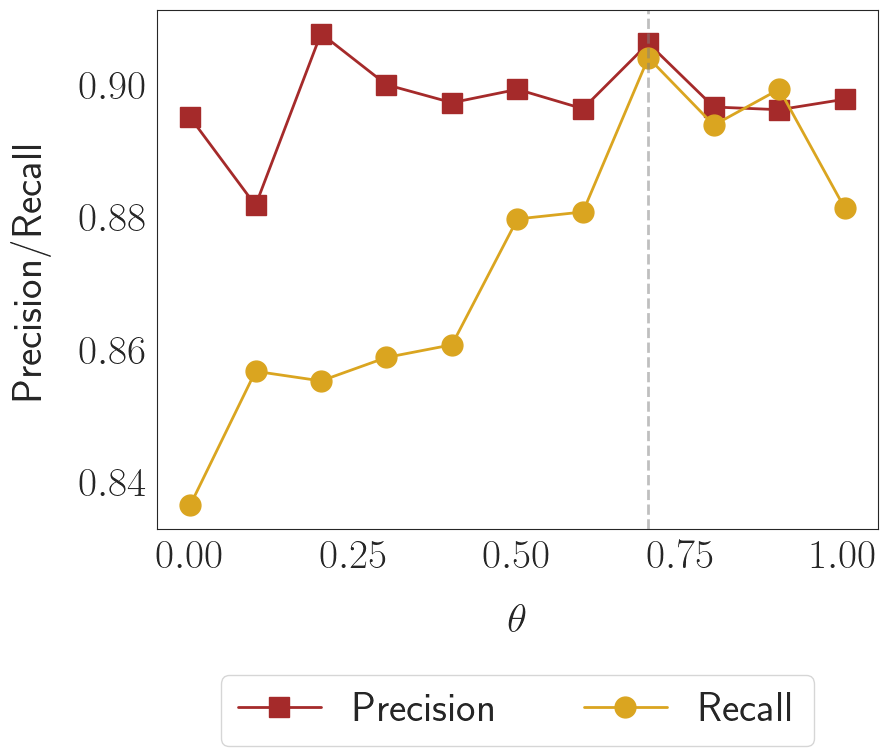

In [5]:
thetas = 0.1*np.arange(11)
precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
colors = ['brown', 'goldenrod']

for i, theta in enumerate(thetas):
    dir = get_results_path(experiment_name, 5, 32, 5, np.round(theta,1))
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)

print(precisions)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, marker='o',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Precision/Recall', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.35), ncol=3)
plt.tight_layout()
plt.show()

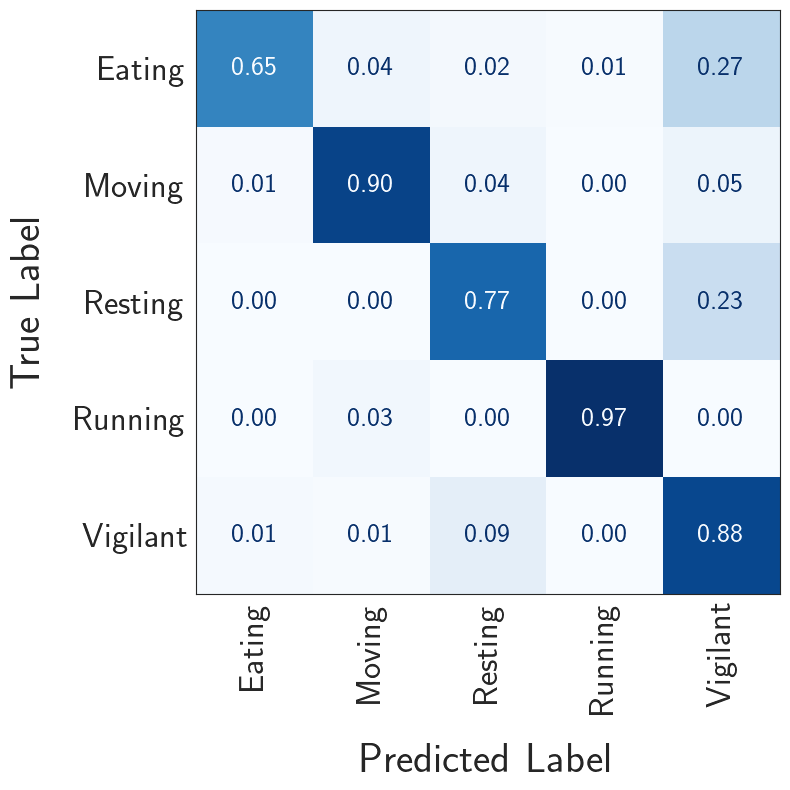

In [6]:
dir = get_results_path(experiment_name, 5, 32, 5, 0.0)
plot_path = os.path.join(get_figures_dir(), f'{experiment_name}-confusion_mat_theta0.0.png')
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=plot_path)

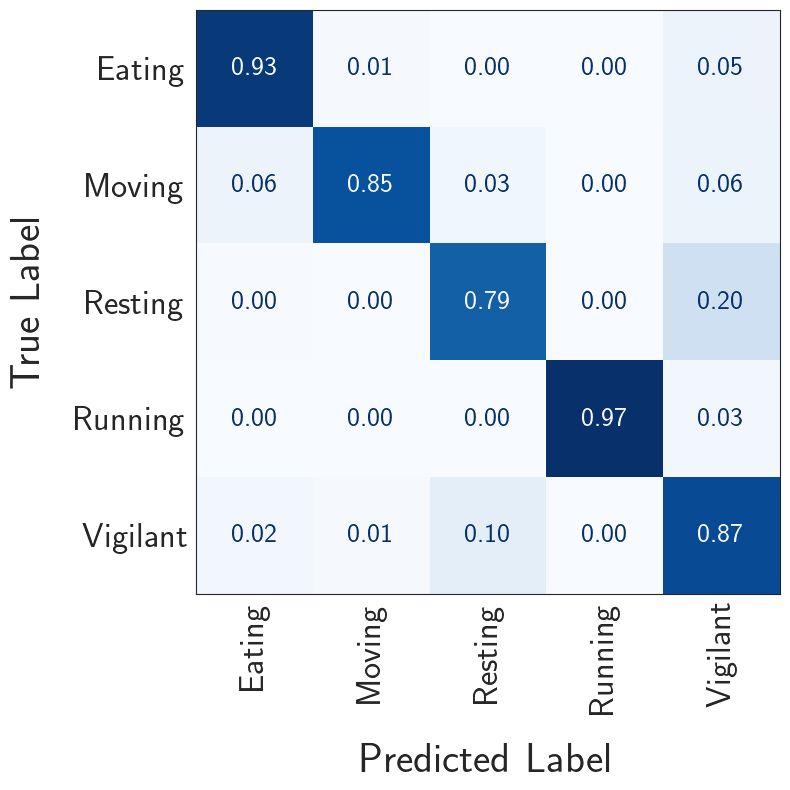

In [7]:
dir = get_results_path(experiment_name, 5, 32, 5, 0.7)
plot_path = os.path.join(get_figures_dir(), f'{experiment_name}-confusion_mat_theta0.7.png')
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=plot_path)

In [8]:
test_accuracies = multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True)
val_accuracies = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True)
print(f"Test accuracies: {np.mean(test_accuracies)}")
print(f"Val accuracies: {np.mean(val_accuracies)}")

Test accuracies: 0.8538334252619967
Val accuracies: 0.8709677419354839


In [9]:
print('PRECISION SCORE')
print('---------------------')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average=None), 2)}))

print('RECALL SCORE')
print('---------------------')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average=None), 2)}))

print('F1 SCORE')
print('---------------------')
print(pd.DataFrame({'behavior': BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average=None), 2)}))

PRECISION SCORE
---------------------
   behavior  precision
0    Eating       0.83
1   Resting       0.95
2    Moving       0.81
3   Running       0.95
4  Vigilant       0.86
RECALL SCORE
---------------------
   behavior  precision
0    Eating       0.93
1   Resting       0.85
2    Moving       0.79
3   Running       0.97
4  Vigilant       0.87
F1 SCORE
---------------------
   behavior  precision
0    Eating       0.88
1   Resting       0.90
2    Moving       0.80
3   Running       0.96
4  Vigilant       0.86


In [10]:
class Arguments:
        def __init__(self, experiment_name, 
                     batch_size, 
                     duration_percentile,
                     train_test_split,
                     train_val_split,
                     padding, 
                     theta,
                     filter_type,
                     cutoff_frequency,
                     cutoff_order,
                     normalization,
                     match,
                     min_duration):
                self.experiment_name = experiment_name
                self.batch_size = batch_size
                self.duration_percentile = duration_percentile
                self.train_test_split = train_test_split
                self.train_val_split = train_val_split
                self.padding = padding
                self.theta = theta
                self.filter_type = filter_type
                self.cutoff_frequency = cutoff_frequency
                self.cutoff_order = cutoff_order
                self.normalization = normalization
                self.match = match
                self.min_duration = min_duration


args = Arguments(experiment_name=experiment_name, 
                batch_size=64, 
                duration_percentile=50, 
                train_test_split=0.2, 
                train_val_split=0.2, 
                padding='repeat', 
                theta=0.8, 
                filter_type='high', 
                cutoff_frequency=0, 
                cutoff_order=5, 
                normalization=0,
                match=0,
                min_duration=1.0)

In [11]:
metadata = pd.read_csv(VECTRONICS_METADATA_PATH) # load metadata
all_annotations = combined_annotations(AWD_VECTRONICS_PATHS, id_mapping) # load annotations 

X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, label_encoder = setup_data_objects(metadata, 
                                                                                                    all_annotations, 
                                                                                                    COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    BEHAVIORS, 
                                                                                                    args, 
                                                                                                    reuse_behaviors=['Eating', 'Moving', 'Running']) 
train_dataloader, val_dataloader, test_dataloader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)

Using pre-matched acceleration-behavior pairs...


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)


print("Class distribution of train set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_train, return_counts=True)[1]}))
print("")

print("Class distribution of validation set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_val, return_counts=True)[1]}))
print("")

print("Class distribution of test set")
print('--------------------------------')
print(pd.DataFrame({'Behavior': label_encoder.inverse_transform(np.arange(5)), 'Proportion': np.unique(y_test, return_counts=True)[1]}))
print("")


(3074, 3, 206) (769, 3, 206) (3237, 3, 206)
Class distribution of train set
--------------------------------
   Behavior  Proportion
0    Eating         251
1    Moving         345
2   Resting         925
3   Running          20
4  Vigilant        1533

Class distribution of validation set
--------------------------------
   Behavior  Proportion
0    Eating          63
1    Moving          86
2   Resting         231
3   Running           5
4  Vigilant         384

Class distribution of test set
--------------------------------
   Behavior  Proportion
0    Eating         175
1    Moving         305
2   Resting        1021
3   Running         160
4  Vigilant        1576



/home/medhaaga/miniconda3/envs/wildlife/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,



The true behavior is Eating and the RAPS is ['Eating' 'Resting'] with scores [0.90611404 0.11170796]

The true behavior is Moving and the RAPS is ['Resting'] with scores [0.99357855]

The true behavior is Resting and the RAPS is ['Moving'] with scores [0.8479975]


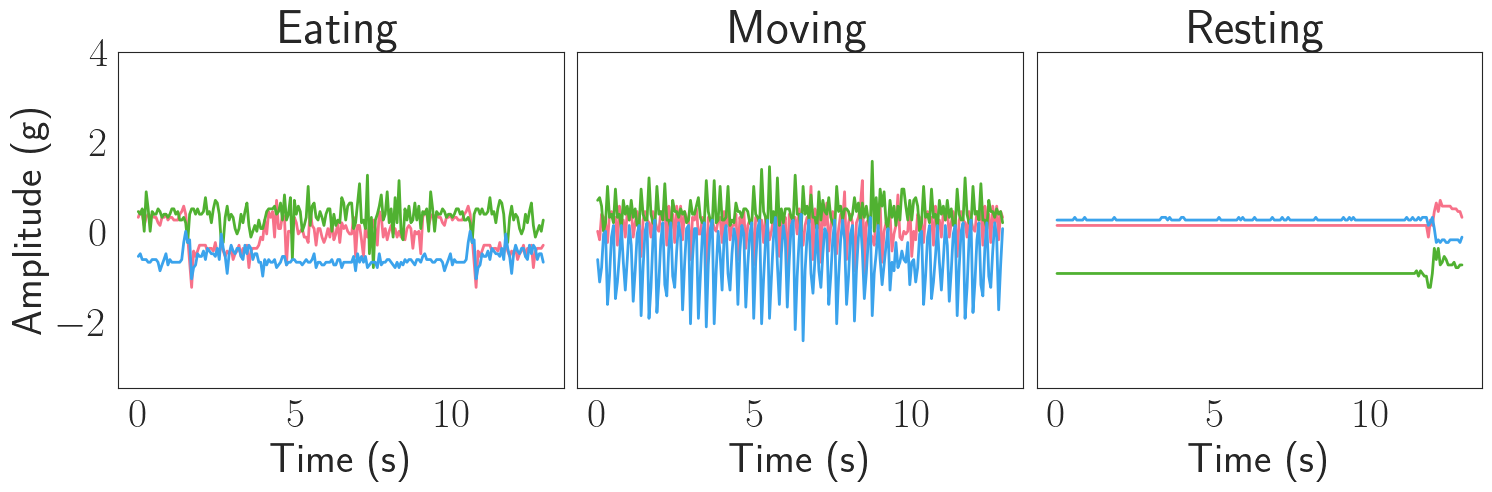

The true behavior is Running and the RAPS is ['Running'] with scores [0.99037665]
The true behavior is Vigilant and the RAPS is ['Vigilant' 'Moving'] with scores [0.7129666  0.31584352]


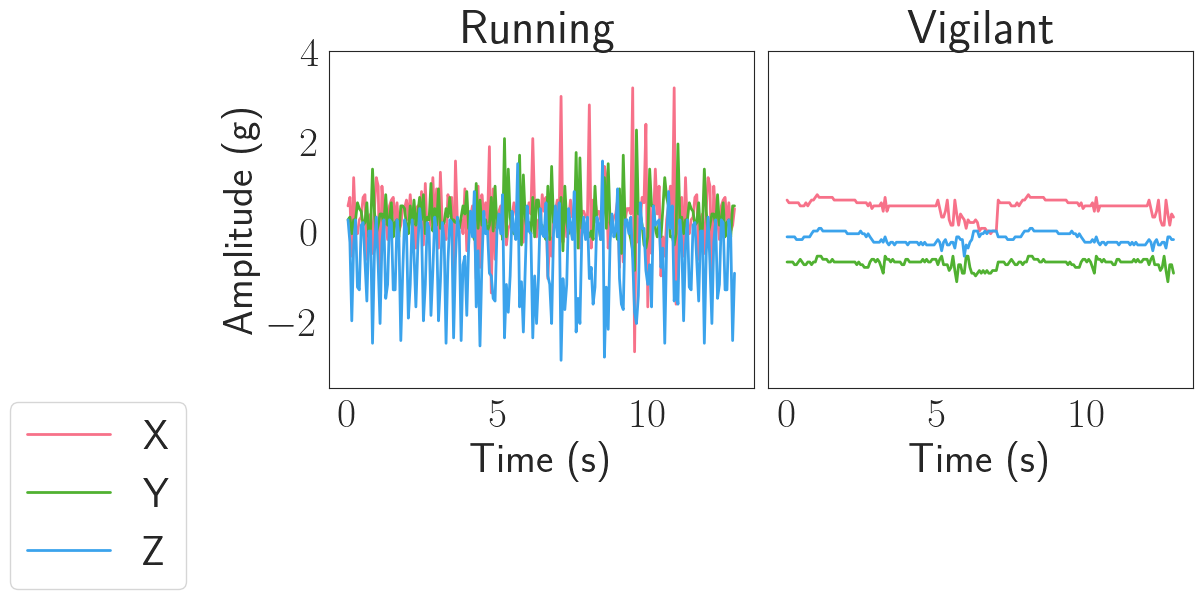

In [12]:
# For example: the prediction sets for a random sample of 10 observations is:
np.random.seed(seed=12)
cmodel = torch.load(os.path.join(dir, 'cmodel.pt'))
cmodel = cmodel.to(device)
idx = [np.random.choice(np.where(y_test == i)[0]) for i in range(len(BEHAVIORS)) ]
colors = sns.color_palette('husl', 3)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for n,i in enumerate(idx[:3]):
    with torch.no_grad():
        acc, target = torch.tensor(X_test[i], dtype=torch.float32), label_encoder.inverse_transform([y_test[i]])[0]
        scores, set = cmodel(acc.unsqueeze(0).to(device))
        axs[n].plot(np.arange(acc.shape[1])/16, acc[0], color=colors[0], label='X', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[1], color=colors[1], label='Y', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[2], color=colors[2], label='Z', linewidth=2)
        axs[n].set_title(target)
        axs[n].set_ylim(-3.5, 4)
        axs[n].set_xlabel('Time (s)')
    print("")
    print(f'The true behavior is {target} and the RAPS is {label_encoder.inverse_transform(set[0])} with scores {scores.cpu().numpy()[0][set[0]]}')
axs[0].set_ylabel('Amplitude (g)')
fig.tight_layout(pad=1.0)
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for n,i in enumerate(idx[3:]):
    with torch.no_grad():
        acc, target = torch.tensor(X_test[i], dtype=torch.float32), label_encoder.inverse_transform([y_test[i]])[0]
        scores, set = cmodel(acc.unsqueeze(0).to(device))
        axs[n].plot(np.arange(acc.shape[1])/16, acc[0], color=colors[0], label='X', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[1], color=colors[1], label='Y', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[2], color=colors[2], label='Z', linewidth=2)
        axs[n].set_title(target)
        axs[n].set_ylim(-3.5, 4)
        axs[n].set_xlabel('Time (s)')
    print(f'The true behavior is {target} and the RAPS is {label_encoder.inverse_transform(set[0])} with scores {scores.cpu().numpy()[0][set[0]]}')
axs[0].set_ylabel('Amplitude (g)')
fig.tight_layout(pad=1.0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='right',
        bbox_to_anchor=(0.0, 0), ncol=1)
plt.show()

In [13]:
ctraindataloader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)), batch_size=args.batch_size, shuffle=False)
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=args.batch_size, shuffle=False)

# coverage of top1, top2, and RAPS predictive sets on train data
train_top1, train_topK, train_coverage, train_size = validate(ctraindataloader, cmodel, print_bool=True, topk=(1,2))

# coverage of top1, top2, and RAPS predictive sets on test data
test_top1, test_topK, test_coverage, test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 3444 | Avg Time: 0.004 | Avg Cvg@1: 0.558 | Avg Cvg@K: 0.617 | Avg Cvg@RAPS: 0.580 | Avg Size@RAPS: 1.154

N: 2098 | Avg Time: 0.003 | Avg Cvg@1: 0.435 | Avg Cvg@K: 0.565 | Avg Cvg@RAPS: 0.478 | Avg Size@RAPS: 1.230

